# PyTorch Bring your own Model
본 노트북은 PyTorch 로 이미 학습된 모델이 있는 경우 이를 AWS의 관리형 ML 추론 서비스인 SageMaker 호스팅환경에 Endpoint로 생성하고 추론서비스를 실행하는 방법을 다룹니다.
아래 블로그와 소스코드를 중심으로 내용을 추가하고 한글로 재정리하였니다. 

- blog : http://francescopochetti.com/fast-neural-style-transfer-sagemaker-deployment/#Saving_the_model_to_disk_and_uploading_to_S3
- source : https://github.com/gabrielelanaro/ml-prototypes.git

PyTorch 모델 Serving을 위한 AWS의 공식 가이드는 아래를 참고하세요.
- https://sagemaker.readthedocs.io/en/stable/frameworks/pytorch/using_pytorch.html#the-sagemaker-pytorch-model-server

## 1. PyTorch 모델 다운로드

- 이미 학습이 완료된 모델로부터 시작하겠습니다. 사용할 모델은 아래 그림처럼 다른 화풍으로 Style Transfer를 실행하는 ML 모델입니다.

![](./img/styletransfer.png)

- 다음 git 코드를 clone받고 학습이 완료된 모델 파일을 살펴봅니다. 
- 세 개의 경로 ('kandinsky','picasso','vangogh')에 각 화가의 화풍으로 Style transfrer할 수 있는 모델이 저장되어 있습니다.

In [1]:
!git clone https://github.com/gabrielelanaro/ml-prototypes.git

Cloning into 'ml-prototypes'...
remote: Enumerating objects: 89, done.
remote: Counting objects: 100% (89/89), done.
remote: Compressing objects: 100% (64/64), done.
remote: Total 926 (delta 47), reused 63 (delta 25), pack-reused 837
Receiving objects: 100% (926/926), 63.60 MiB | 79.81 MiB/s, done.
Resolving deltas: 100% (486/486), done.


In [2]:
styles = ['kandinsky','picasso','vangogh']
modelpath = 'ml-prototypes/prototypes/styletransfer/fast_neural_st/' + styles[0]
modelpath

'ml-prototypes/prototypes/styletransfer/fast_neural_st/kandinsky'

In [3]:
!ls {modelpath}/

model.pth  model.tar.gz


* model.tar.gz의 파일 구조 살펴보기

In [4]:
!tar zvft ml-prototypes/prototypes/styletransfer/fast_neural_st/{styles[0]}/model.tar.gz 

drw-r--r-- 0/0               0 1970-01-01 00:00 models/
-rw-rw-r-- ec2-user/ec2-user 6729038 2019-08-26 16:23 model.pth


- model.pth 파일을 tarball로 생성한 파일입니다.
- 해당 파일은 아래와 유사한 코드를 이용하여 생성하였을 것입니다.

```python
import tarfile
style = "vangogh" # or whatever other style
with tarfile.open(f'./{style}/model.tar.gz', 'w:gz') as f:
    t = tarfile.TarInfo('models')
    t.type = tarfile.DIRTYPE
    f.addfile(t)
    f.add(f'{style}/model.pth', arcname='model.pth')
 
```


---
## 2. 추론용 스크립트 작성

- PyTorch와 같은 범용 딥러닝 프레임워크를 기반으로 개발한 모델을 SageMaker 환경에서 호스팅하는 추론서비스로 배포할 때, 추론용 컨테이너와 서버리소스는 SageMaker에서 제공하지만 추론 실행코드는 (개발된 모델마다 코드가 달리지므로) 사용자가 직접 정의해야 합니다. 
- 사용자 추론코드는 다음 4개의 함수를 구현해야 합니다.
    + model_fn() - 모델 경로를 주고 모델을 로드하고 리턴하는 함수
    + input_fn() - request body로부터 input object를 생성하는 함수 (전처리 함수)
    + prediction_fn() - input object를 이용하여 model을 호출하고 추론실행
    + output_fn() - 추론실행 결과로부터 response 생성하는 함수 (후처리 함수)
  
  
- 추론 스크립트의 실행단계별로 역할관계를 이해하기 위해 다음 그림을 참고합니다.
  
![](./img/BYOM.png)

- 라이브러리 로드

In [5]:
import boto3
import json

JSON_CONTENT_TYPE = 'application/json'
JPEG_CONTENT_TYPE = 'image/jpeg'

# 신경망 모델의 구성과 IO관련 변환을 위한 유틸리티 라이브러리를 로드합니다. 이부분은 사용될 모델에 따라 달라질 것입니다.
from TransformerNet import *
from st_util import *

### 2-1. model_fn()
- model위 위치한 경로를 입력받아 PyTorch 모델을 리턴하는 함수 

In [6]:
def model_fn(model_dir):
    device = torch.device("cpu")
    model = TransformerNet()
    with open(os.path.join(model_dir, 'model.pth'), 'rb') as f:
        model.load_state_dict(torch.load(f, map_location=device))
    return model.to(device)
# test
# model = model_fn('ml-prototypes/prototypes/styletransfer/fast_neural_st/' + styles[0])
# model

### 2-2. input_fn()

- request body 를 이미지로 받아서 필요한 전처리를 실행한 후 model 추론용 input object를 리턴합니다. 
- 전처리는 일반적으로 모델 학습단계에서 여러 실험들을 거치면서 결정되었을 것입니다. 만약 Training과 Serving업무가 분리되어 운영된다면, Training 완료된 모델이 Serving 업무로 전달될 때 전처리코드 또는 가이드가 함께 전달될 것입니다.
- 본 예제코드는 Bytes > PIL.Image > Resize/Normalization/...(transformation) 의 과정을 거쳐 최종 predict_fn()에서 필요한 포맷으로 변환되었습니다.
- 전체리에 사용된 MakeRGB, ResizeFixed, ToByteTensor 등 함수는 st_util.py 코드를 참고하십시오.

In [7]:
def input_fn(request_body, content_type=JPEG_CONTENT_TYPE):
    img = PIL.Image.open(io.BytesIO(request_body))
    item = {'input': img}
 
    rgb = MakeRGB()
    resized = ResizeFixed(size)
    tobyte = ToByteTensor()
    tofloat = ToFloatTensor()
    norm = Normalize(imagenet_stats, padding)
    tmfs = [rgb, resized, tobyte, tofloat, norm]
    item = compose(item, tmfs)
    return {'img': item['input'], 'size': img.size}

# 테스트 
# x = open("img/deepracer.jpg", mode='rb')
# input_fn(x.read())

### 2-3. predict_fn()

- input_object와 model을 입력받아 추론을 실행하고 결과를 리턴합니다.

In [8]:
def predict_fn(input_object, model):
    img = input_object['img']
    device = torch.device("cpu")
    out = model(img[None].to(device))
    input_object['img'] = out[0].detach()
    return input_object

# 테스트
# x = open("img/deepracer.jpg", mode='rb')
# predict_fn(input_fn(x.read()), model)

### 2-4. output_fn()

- 추론 실행결과를 출력 content_type에 맞게 변환하여 리턴합니다.
- 본 예제에서는 이미지가 결과물을 base64로 인코딩하고 json의 형태로 리턴하고 있습니다. 

In [9]:
def output_fn(prediction, content_type=JSON_CONTENT_TYPE):
    p = prediction['img']
    original_size = prediction['size']
    denorm = DeProcess(imagenet_stats, size, padding, original_size)
    pred = denorm(p)
    if content_type == JSON_CONTENT_TYPE:
        return json.dumps({'prediction': image_to_base64(pred).decode()})

# 테스트
# x = open("img/deepracer.jpg", mode='rb')
# output_fn(predict_fn(input_fn(x.read()), model))

### 2-5. 4개의 함수 연결테스트

- 임의의 이미지와 모델로부터 추론을 실행해 봅니다. 
- output_fn()의 결과는 base64로 인코딩된 이미지를 포함하는 json파일이므로, 결과확인을 위해 리턴된 응답을 다시 이미지 형태로 디코딩하였습니다.

In [10]:
x = open("img/deepracer.jpg", mode='rb')
model = model_fn('ml-prototypes/prototypes/styletransfer/fast_neural_st/' + styles[0])
output = output_fn(predict_fn(input_fn(x.read()), model))

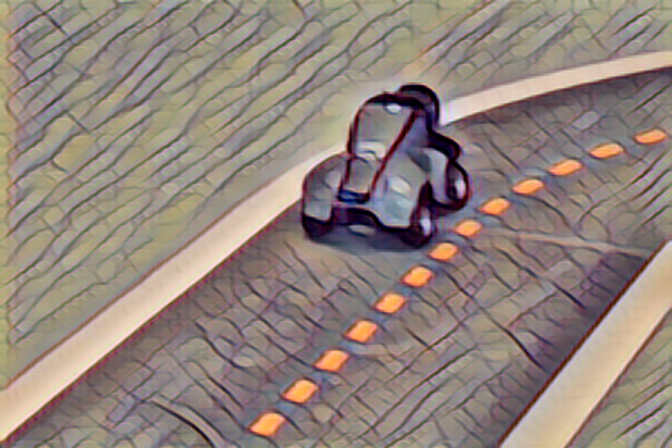

In [11]:
import json 
base64_to_image(json.loads(output)['prediction'])

### 2-6. inference.py 작성

- 앞서 작성한 4개의 함수로 구성된 inference.py를 작성합니다.

In [12]:
%%writefile inference.py
from TransformerNet import *
from st_util import *

JSON_CONTENT_TYPE = 'application/json'
JPEG_CONTENT_TYPE = 'image/jpeg'

def model_fn(model_dir):
    device = torch.device("cpu")
    model = TransformerNet()
    with open(os.path.join(model_dir, 'model.pth'), 'rb') as f:
        model.load_state_dict(torch.load(f, map_location=device))
    return model.to(device)

def input_fn(request_body, content_type=JPEG_CONTENT_TYPE):
    img = PIL.Image.open(io.BytesIO(request_body))
    item = {'input': img}
 
    rgb = MakeRGB()
    resized = ResizeFixed(size)
    tobyte = ToByteTensor()
    tofloat = ToFloatTensor()
    norm = Normalize(imagenet_stats, padding)
    tmfs = [rgb, resized, tobyte, tofloat, norm]
    item = compose(item, tmfs)
    return {'img': item['input'], 'size': img.size}

def predict_fn(input_object, model):
    img = input_object['img']
    device = torch.device("cpu")
    out = model(img[None].to(device))
    input_object['img'] = out[0].detach()
    return input_object

def output_fn(prediction, content_type=JSON_CONTENT_TYPE):
    p = prediction['img']
    original_size = prediction['size']
    denorm = DeProcess(imagenet_stats, size, padding, original_size)
    pred = denorm(p)
    if content_type == JSON_CONTENT_TYPE:
        return json.dumps({'prediction': image_to_base64(pred).decode()})


Writing inference.py


- 사용된 파일을 src_dir 폴더에 복사해 두겠습니다. (이후 이 파일들을 SageMaker호스팅 환경으로 보내게 될 것입니다.)

In [13]:
# !rm -Rf src_dir
!mkdir src_dir
!cp inference.py TransformerNet.py st_util.py src_dir/



---
## 3. SageMaker Hosting 환경 설정

### 3-1. Upload model.tar.gz into S3

- 모델 파일을 S3로 저장합니다. 

In [20]:
import sagemaker as SM
SM_session = SM.Session()
bucket = "leonkang-datalake-oregon"
model_artifacts = []

for style in styles:
    path = 'ml-prototypes/prototypes/styletransfer/fast_neural_st/' + style
    prefix = 'style-transfer/' + style
    model_artifact = SM_session.upload_data(path=f'./{path}/model.tar.gz', bucket=bucket, key_prefix=prefix)
    model_artifacts.append(model_artifact)

In [21]:
model_artifacts

['s3://leonkang-datalake-oregon/style-transfer/kandinsky/model.tar.gz',
 's3://leonkang-datalake-oregon/style-transfer/picasso/model.tar.gz',
 's3://leonkang-datalake-oregon/style-transfer/vangogh/model.tar.gz']

### 3-2. PyTorch Model 생성

- SageMaker 환경에서 API기반 Serving을 호스팅하기 위해 SageMaker에 다음 세 개의 오브젝트의 설정이 필요합니다.
    + Model - 사용할 콘테이너 이미지, 모델파일(Model artifect)의 위치 등이 관리됩니다.
    + Endpoint Configuration - deploy를 위한 설정을 관리합니다. 배포할 모델과 호스팅될 자원(인스턴스 타입과 수량)이 관리됩니다.  
    + Endpoint - 호스팅되어 운영되는 Serving 서비스입니다. 사용하지 않을 경우에는 삭제하고, 필요시에는 Endpoint Configuration 정보를 이용하여 언제든 다시 생성할 수 있습니다.


- 세 오브젝트 중 SageMaker 모델을 먼저 생성합니다. 본 노트북에서는 PyTorch 컨테이너를 기반으로 Serving하도록 sagemaker.pytorch.PyTorchModel을 이용하여 모델을 생성하고 있습니다.

In [22]:
model_artifact = model_artifacts[0]
model_artifact

's3://leonkang-datalake-oregon/style-transfer/kandinsky/model.tar.gz'

In [23]:
from sagemaker.pytorch import PyTorchModel
role = SM.get_execution_role()
 
from sagemaker.predictor import RealTimePredictor, json_deserializer
 
class ImagePredictor(RealTimePredictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super().__init__(endpoint_name, sagemaker_session=sagemaker_session, serializer=None, 
                         deserializer=json_deserializer, content_type='image/jpeg')
 
pytorch_model = PyTorchModel(model_data=model_artifact, role=role,framework_version='1.0.0', name=style,
                             entry_point='inference.py', source_dir = 'src_dir',
                             predictor_cls=ImagePredictor)


Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


- PyTorchModel 생성시 지정한 파라미터 값을 참고하십시오.(SDK : https://sagemaker.readthedocs.io/en/stable/frameworks/pytorch/sagemaker.pytorch.html#pytorch-model)
    + model_data - model.tar.gz 파일이 있는 s3 위치
    + role - IAM role (s3 접근관리 등), 이후 실행될 Endpoint에서도 이용하게 됨
    + name - endpoint의 이름
    + entry_point - 호스팅에 사용될 파이썬 소스코드 스크립트
    + source_dir - entry_point의 스크립트 및 관련 코드(utility, helper 등) 위치
    + predictor_cls - Predictor 생성시 호출할 함수. endpoint name과 sagemaker session을 매개변수로 받음


- precitor_cls의 ImagePredictor는 RealTimePredictor를 상속받아 구현하였습니다.(SDK : https://sagemaker.readthedocs.io/en/stable/api/inference/predictors.html?highlight=realtimepredictor#sagemaker.predictor.RealTimePredictor)
    + RealTimePredictor는 SageMaker endpoint에 대한 요청을 처리하는 역할을 합니다. 
    - serializer는 API요청 입력을 bytes로 변환할 것입니다. serializer가 지정되지 않을 경우 특별한 변환처리를 하지 않으며, bytes 형태로 호출 필요합니다.
    - deserializer는 응답 bytes를 지정한 형태로 변환합니다. (본 예제에서는 스타일변환 적용 후 image/jpeg형태로 리턴합니다.) 
    


### 3-3. Deploy
- 생성한 모델로부터 .deploy()명령을 실행합니다.
- .deploy()는 실행하면 Endpoint Configuration과 Endpoint을 자동으로 생성됩니다. (아래 코드 실행 후 AWS콘솔을 확인해 보십시오.)
- 호스팅될 자원환경(인스턴스 타입과 수량)을 파라미터로 지정하였습니다.


In [24]:
# sm = boto3.client('sagemaker')
# sm.list_endpoints()
# sm.delete_endpoint(EndpointName='vangogh')


In [25]:
predictor = pytorch_model.deploy(initial_instance_count=1, instance_type='ml.c5.large')

'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


-----------!

## 4. Inference 

In [26]:
import base64
import io
import matplotlib.pyplot as plt
from PIL import Image

#### 4-1. deploy에서 사용한 predictor 호출

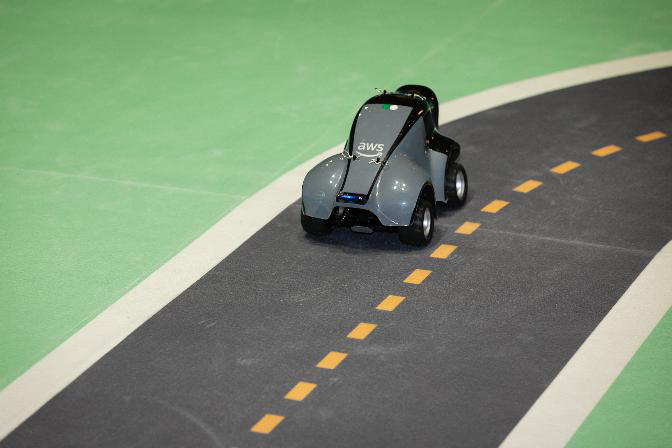

In [28]:
Image.open('img/deepracer.jpg')

In [30]:
resp41 = predictor.predict(open("img/deepracer.jpg", mode='rb'))

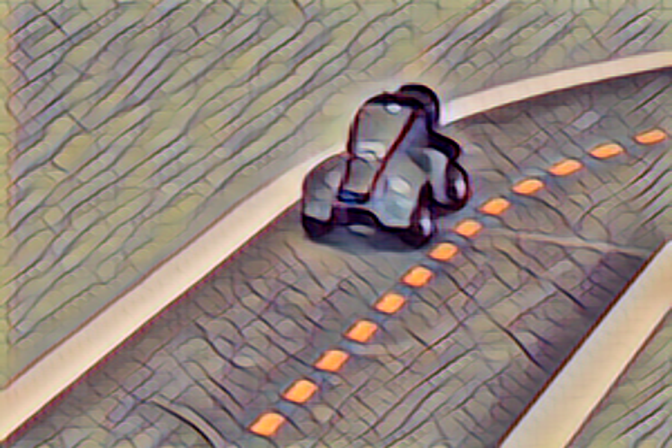

In [31]:
img_vangogh41 = base64.b64decode(resp41['prediction'])
Image.open(io.BytesIO(img_vangogh41))

#### 4-2. SageMaker api로부터 Endpoint에 대한 predictor 생성하여 호출

In [32]:
import boto3, json
from sagemaker.predictor import json_serializer, json_deserializer, RealTimePredictor
# from sagemaker_inference import content_types, decoder
# from sagemaker.content_types import CONTENT_TYPE_CSV, CONTENT_TYPE_JSON
from sagemaker import Session
sess = Session()

endpoint_name = 'vangogh'
runtime = boto3.Session().client('runtime.sagemaker')
my_endpoint = endpoint_name

In [33]:
my_predictor = RealTimePredictor(endpoint=my_endpoint, sagemaker_session=sess, serializer=json_serializer, deserializer=json_deserializer,
                                 content_type = 'application/x-image')

In [34]:
resp42 = my_predictor.predict(open("img/deepracer.jpg", mode='rb'))

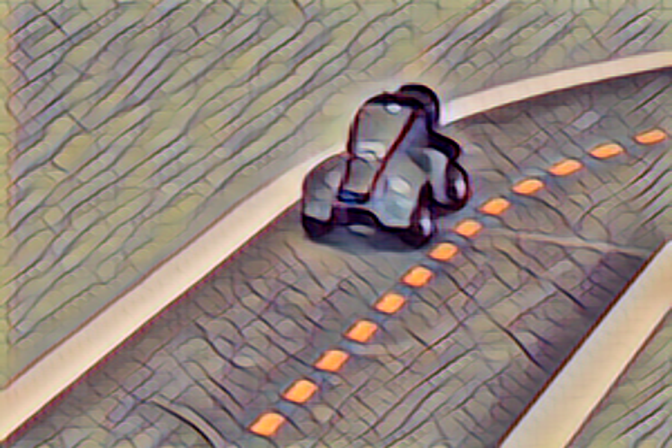

In [35]:
img_vangogh42 = base64.b64decode(resp42['prediction'])
Image.open(io.BytesIO(img_vangogh42))

### 4-3. boto3 sdk로부터 invoke_endpoint 호출

In [38]:
import boto3

endpoint_name = "vangogh"                
runtime = boto3.Session().client(service_name='sagemaker-runtime',region_name='us-west-2')

In [39]:
img = open("img/deepracer.jpg", mode='rb')
# payload = bytearray(img)
response = runtime.invoke_endpoint(EndpointName=endpoint_name, ContentType='application/x-image', Body=img)
resp43 = response.get('Body').read().decode()

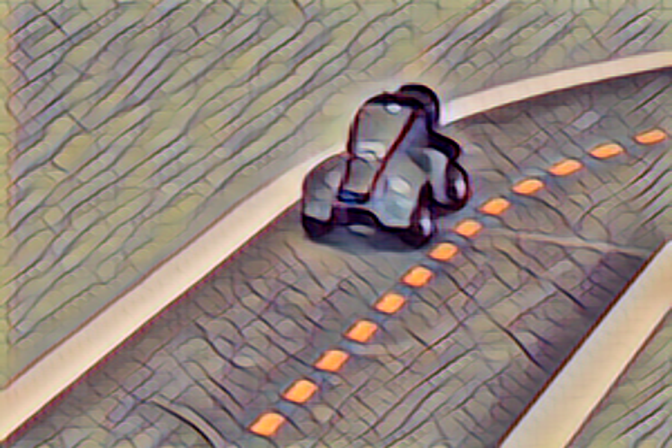

In [40]:
img_vangogh43 = base64.b64decode(json.loads(resp43)['prediction'])
Image.open(io.BytesIO(img_vangogh43))

## 5. Mutlti model dployment

작업중

In [ ]:

with open(file_name, 'rb') as f:

payload = f.read()

payload = bytearray(payload)

response = runtime.invoke_endpoint(EndpointName=endpoint_name, ContentType='application/x-image', Body=payload)

#response = runtime.invoke_endpoint(EndpointName=endpoint_name, ContentType='application/x-npy', Body=payload)

​

In [84]:
def compose(x, funcs, *args, order_key='_order', **kwargs):
    key = lambda o: getattr(o, order_key, 0)
    for f in sorted(list(funcs), key=key): x = f(x, **kwargs)
    return x

class Transform(): _order=0
        
class MakeRGB(Transform):
    def __call__(self, item): return {k: v.convert('RGB') for k, v in item.items()}

class ResizeFixed(Transform):
    _order=10
    def __init__(self, size):
        if isinstance(size,int): size=(size,size)
        self.size = size
        
    def __call__(self, item): return {k: v.resize(self.size, PIL.Image.BILINEAR) for k, v in item.items()}

class ToByteTensor(Transform):
    _order=20
    def to_byte_tensor(self, item):
        res = torch.ByteTensor(torch.ByteStorage.from_buffer(item.tobytes()))
        w,h = item.size
        return res.view(h,w,-1).permute(2,0,1)
    
    def __call__(self, item): return {k: self.to_byte_tensor(v) for k, v in item.items()}


class ToFloatTensor(Transform):
    _order=30
    def to_float_tensor(self, item): return item.float().div_(255.)
    
    def __call__(self, item): return {k: self.to_float_tensor(v) for k, v in item.items()}
    
class Normalize(Transform):
    _order=40
    def __init__(self, stats, p=None):
        self.mean = torch.as_tensor(stats[0] , dtype=torch.float32)
        self.std = torch.as_tensor(stats[1] , dtype=torch.float32)
        self.p = p
    
    def normalize(self, item): return item.sub_(self.mean[:, None, None]).div_(self.std[:, None, None])
    def pad(self, item): return nn.functional.pad(item[None], pad=(self.p,self.p,self.p,self.p), mode='replicate').squeeze(0)
    
    def __call__(self, item): 
        if self.p is not None: return {k: self.pad(self.normalize(v)) for k, v in item.items()}
        else: return {k: self.normalize(v) for k, v in item.items()}

In [105]:
# img = PIL.Image.open(io.BytesIO(request_body))
item = {'input': img}

In [106]:
x = MakeRGB()

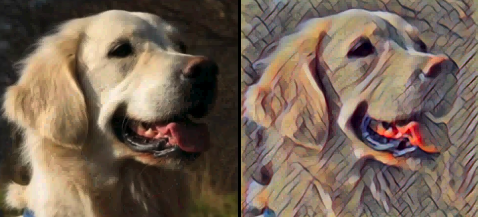

In [108]:
x(item)['input']

In [67]:
import imp

In [71]:
imp.reload(TransformerNet)

<module 'TransformerNet' from '/home/ec2-user/SageMaker/Torch_model_invoke/TransformerNet.py'>

In [35]:
import torch

In [60]:
import TransformerNet as TN

In [72]:
dir(TransformerNet)

['ConvLayer',
 'ResidualBlock',
 'TransformerNet',
 'UpsampleConvLayer',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'torch']

In [73]:
TransformerNet.TransformerNet()

TransformerNet(
  (conv1): ConvLayer(
    (reflection_pad): ReflectionPad2d((4, 4, 4, 4))
    (conv2d): Conv2d(3, 32, kernel_size=(9, 9), stride=(1, 1))
  )
  (in1): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  (conv2): ConvLayer(
    (reflection_pad): ReflectionPad2d((1, 1, 1, 1))
    (conv2d): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
  )
  (in2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  (conv3): ConvLayer(
    (reflection_pad): ReflectionPad2d((1, 1, 1, 1))
    (conv2d): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2))
  )
  (in3): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  (res1): ResidualBlock(
    (conv1): ConvLayer(
      (reflection_pad): ReflectionPad2d((1, 1, 1, 1))
      (conv2d): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    )
    (in1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (

In [57]:
TransformerNet.mymodel()

AttributeError: module 'TransformerNet' has no attribute 'mymodel'

In [56]:
dir(TransformerNet)

['__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__']